In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [3]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/METADATA_CURRENT.txt', sep='\t')

# gencode 25
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')


P_Set = pd.read_csv('tmp_res/SET1.txt', sep='\t')

R_Set = pd.read_csv('tmp_res/SET2.txt', sep='\t')

R_Set['pos_of_codon'] = [int(x.split('; ')[1].split('-')[0])-1 for x in R_Set.Riboseq_Summary.tolist()]

R_Set['codon'] = [x.split('; ')[0] for x in R_Set.Riboseq_Summary.tolist()]

R_Set[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,97,ATC
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,172,ACG


In [4]:
meta_mice14 = pd.read_csv('tmp_res/meta_mice_M14.txt', sep='\t')

meta_mice14[0:2]

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id
0,ENSMUST00000070533.4,Xkr4,Xkr4-201,GCGGCGGCGGGCGAGCGGGCGCTGGAGTAGGAGCTGGGGAGCGGCG...,GCGGCGGCGGGCGAGCGGGCGCTGGAGTAGGAGCTGGGGAGCGGCG...,ATC,ATGGCCGCTAAGTCAGACGGGAGGCTGAAGATGAAGAAGAGCAGCG...,ATG,TAA,150,2094,0,150,ENSMUST00000070533.4|ENSMUSG00000051951.5|OTTM...
1,ENSMUST00000208660.1,Rp1,Rp1-203,AAGCTCAGCCTTTGCTCAGATTCTCCTCTTGATGAAACAAAGGGAT...,AAGCTCAGCCTTTGCTCAGATTCTCCTCTTGATGAAACAAAGGGAT...,CAC,ATGCTTGAGAAATTGCAGGTCTCACCCAAAATGAGTGACACACCTT...,ATG,TAG,54,4170,0,54,ENSMUST00000208660.1|ENSMUSG00000025900.12|OTT...


# Human and Mouse homologous genes (RiboSET and PhyloSET)

### by name 

In [5]:
r_set = [x[0:1] + x[1:].lower() for x in R_Set['gene'].tolist()]

p_set = [x[0:1] + x[1:].lower() for x in list(P_Set['gene'].unique())]

len(r_set), len(p_set)

(395, 60)

In [6]:
# downloaded 
f = pd.read_csv('data/human_mouse_orthologs.txt', sep='\t')

In [7]:
# get missing genes 

RSet_d = {'SUPT16H':'Supt16',
 'CTD-2135J3.4':None,
 'KRTAP2-3':'Krtap2-4',
 'C9ORF16':None,  # Bbln no in data 
 'UBE2D2':'Ube2d2b',   # Ube2d2b
 'ZNF629':'Zfp629',
 'ZNF316':'Zfp316',
 'C18ORF8':None,
 'HM13':'H13',
 'CCT6A':None, # Cct6a not in file
 'C16ORF72':None,
 'UFD1L':'Ufd1',
 'ZNF428':'Zfp428',
 'CD59':'Cd59a', #Cd59b
 'CD99':'Cd99l2',
 'SLC25A6':'Slc25a5',
 'FTL':'Ftl1',
 'INSL4':None,
 'SUPT4H1':'Supt4a',
 'ZNF384':'Zfp384',
 'MFAP1':'Mfap1a', #Mfap1b
 'ZNF622':'Zfp622',
 'KRBOX4':'Zfp78',
 'AC013461.1':'Map3k20',
 'FAM92A1':'Fam92a' # Fam92b
         }


PSet_d = {
    'TBC1D29':None,
 'KIAA0930':'5031439G07Rik', #???
 'POMZP3':'Zp3',
 'PABPC1L2A':'Pabpc1l',
 'AC007906.1':None,
 'GDF5OS':'Gm15557',
 'LRP5L':None,
 'SLC35G5':'Slc35g3',
 'PABPC1L2B':'Pabpc1l', #???
 'WWC3': None, # wwc1, 2
 'ZBTB47':'Zfp651'
}

In [8]:
tmp1 = meta_mice14[meta_mice14['gene'].isin(r_set)][['gene']].drop_duplicates()
tmp1.columns = ['gene_mouse']
tmp1['gene_human'] = [x.upper() for x in tmp1['gene_mouse']]

print (tmp1.gene_human.nunique())

li = []

tmp2 = pd.DataFrame({'gene_mouse':list(RSet_d.values()),
                    'gene_human':list(RSet_d.keys())})

#print (tmp2.gene_human.nunique())

R_Set_match = pd.concat([tmp1, tmp2])

print (R_Set_match.gene_human.nunique())

# 25 huamn ribo-seq genes do not have mouse othologs? 

367
392


In [9]:
tmp1 = meta_mice14[meta_mice14['gene'].isin(p_set)][['gene']].drop_duplicates()
tmp1.columns = ['gene_mouse']
tmp1['gene_human'] = [x.upper() for x in tmp1['gene_mouse']]

print (tmp1.gene_human.nunique())

li = []

tmp2 = pd.DataFrame({'gene_mouse':list(PSet_d.values()),
                    'gene_human':list(PSet_d.keys())})

#print (tmp2.gene_human.nunique())

P_Set_match = pd.concat([tmp1, tmp2])

print (P_Set_match.gene_human.nunique())

# 11 huamn phyloset genes do not have mouse othologs? 

49
60


In [10]:
print (P_Set_match.shape[0], P_Set_match[P_Set_match['gene_mouse'].notna()].shape[0])
P_Set_match[0:3]

60 56


,gene_mouse,gene_human
2062,C1ql2,C1QL2
2117,Map3k19,MAP3K19
3242,Vangl2,VANGL2


In [11]:
print (R_Set_match.shape[0], R_Set_match[R_Set_match['gene_mouse'].notna()].shape[0])
R_Set_match[0:3]

392 386


,gene_mouse,gene_human
359,Fam168b,FAM168B
365,Plekhb2,PLEKHB2
496,Txndc9,TXNDC9


# Test Plot 

12339
0


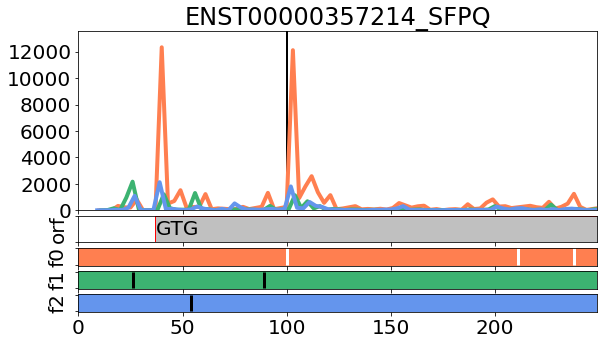

In [12]:
gene = 'SFPQ'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

# Trips-viz mice predictions 

In [13]:
transl_with_all_codons = pd.read_csv('data/mouse_nte_all_starts.csv', sep=',')

# Rapino18, Sendoel17, CasteloSzekely17, Neri17, Hornstein16, and Das19. 

print (transl_with_all_codons.columns)
transl_with_all_codons[0:2]

Index(['Gene', 'Tran', 'Start', 'Stop', 'Length', 'Global_Rank', 'Type',
       'Trips-viz link', 'Start Codon', 'Highframe rank', 'Highframe value',
       'Lowframe rank', 'Lowframe value', 'Stop rank', 'Stop value',
       'Start rank', 'Start value', 'Coverage rank', 'Coverage value',
       'Inframe Count Rank', 'Inframe Count Value', 'Amino acid sequence',
       'Proteomics count', 'Read density'],
      dtype='object')


,Gene,Tran,Start,Stop,Length,Global_Rank,Type,Trips-viz link,Start Codon,Highframe rank,...,Stop value,Start rank,Start value,Coverage rank,Coverage value,Inframe Count Rank,Inframe Count Value,Amino acid sequence,Proteomics count,Read density
0,CYB5R3,ENSMUST00000162178,86,122,37,1,extension,"<a href=""https://trips.ucc.ie/mus_musculus/Gen...",GTG,16,...,0.811447,9,5.564520,1,100.0,13,78.583333,VLSPVWFIYSL,0,0.891892
1,P4HB,ENSMUST00000026122,393,447,55,2,extension,"<a href=""https://trips.ucc.ie/mus_musculus/Gen...",TTG,14,...,-2.846227,11,5.456745,9,87.5,22,58.222222,LAVPAAPTQLPRPLQTS,0,0.872727


In [14]:
transl_with_all_codons.columns = ['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 'len_ext', 
                                 'global_rank_ext', 'type_all_codons', 'trips_viz_link', 'Start_codon_ext', 
                                 'Highframe rank', 'Highframe value',
       'Lowframe rank', 'Lowframe value', 'Stop rank', 'Stop value',
       'Start rank', 'Start value', 'Coverage rank', 'Coverage_value_ext',
                                  'Inframe Count Rank', 'Inframe Count Value',
       'Amino acid sequence', 'Proteomics_count_ext', 'Read_density']

transl_with_all_codons2 = transl_with_all_codons[['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 
                                                 'global_rank_ext', 'Start_codon_ext', 
                                                 'Proteomics_count_ext', 'Coverage_value_ext', 'Read_density']]

transl_with_all_codons2['Riboseq_Summary'] = transl_with_all_codons2['Start_codon_ext']+'; '+transl_with_all_codons2['Start_ext'].astype(str)+'-'+transl_with_all_codons2['Stop_ext'].astype(str)+'; Rank: '+transl_with_all_codons2['global_rank_ext'].astype(str)+'; cov: '+np.round(transl_with_all_codons2['Coverage_value_ext'],2).astype(str)


transl_with_all_codons2[0:5]

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,gene_ext,tr_id1,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,Read_density,Riboseq_Summary
0,CYB5R3,ENSMUST00000162178,86,122,1,GTG,0,100.000000,0.891892,GTG; 86-122; Rank: 1; cov: 100.0
1,P4HB,ENSMUST00000026122,393,447,2,TTG,0,87.500000,0.872727,TTG; 393-447; Rank: 2; cov: 87.5
2,COX7C,ENSMUST00000131011,173,230,3,ACG,0,66.666667,0.931034,ACG; 173-230; Rank: 3; cov: 66.67
3,PKM,ENSMUST00000034834,236,296,4,CTG,0,63.157895,0.934426,CTG; 236-296; Rank: 4; cov: 63.16
4,LAPTM4B,ENSMUST00000022867,251,299,5,AAG,0,80.000000,0.918367,AAG; 251-299; Rank: 5; cov: 80.0


In [15]:
len(set(R_Set.gene.tolist()).intersection(transl_with_all_codons2[transl_with_all_codons2['global_rank_ext'] <= 500].gene_ext.tolist()))

65

In [16]:
len(set(P_Set.gene.tolist()).intersection(transl_with_all_codons2[transl_with_all_codons2['global_rank_ext'] <= 500].gene_ext.tolist()))

17

# Remove ovlp with CDS 

In [17]:
def prepare_global_coo(path_to_file_with_global_coo, colname):
    global_coo_g25 = pd.read_csv(path_to_file_with_global_coo, sep='\t')
    global_coo_g25_f = global_coo_g25[global_coo_g25['hit'] == True]
    global_coo_g25_f = global_coo_g25_f.sort_values(by=['seqnames', 'start'])
    global_coo_g25_f['global_coo'] = global_coo_g25_f['seqnames']+':'+global_coo_g25_f['start'].astype(str) +'-'+global_coo_g25_f['end'].astype(str)
    global_coo_g25_f = global_coo_g25_f[['group_name', 'strand', 'global_coo']].groupby(['group_name', 'strand']).agg('+'.join).reset_index()
    global_coo_g25_f.columns = ['tr_id', 'strand', colname]
    return global_coo_g25_f

In [18]:
meta_mice14['tr_id1'] = [x.split('.')[0] for x in meta_mice14['tr_id'].tolist()]

### local coo of predicted extension 

In [19]:
transl_with_all_codons2['start'] = [int(x.split('; ')[1].split('-')[0]) for x in transl_with_all_codons2['Riboseq_Summary'].tolist()]


transl_with_all_codons2['stop'] = [int(x.split('; ')[1].split('-')[1]) for x in transl_with_all_codons2['Riboseq_Summary'].tolist()]


local_df = transl_with_all_codons2[['tr_id1', 'start', 'stop']].merge(meta_mice14[['tr_id', 'tr_id1']])[['tr_id', 'start', 'stop']]

local_df.to_csv('tmp_res/mice14_nte_riboset.txt', sep='\t', index=False)

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
primary_global = prepare_global_coo(path_to_file_with_global_coo='tmp_res/mice14_nte_riboset_global_coo.txt',
                                   colname = 'global_coo_ext')

primary_global

,tr_id,strand,global_coo_ext
0,ENSMUST00000000001.4,-,chr3:108146005-108146040
1,ENSMUST00000000003.13,-,chrX:77853483-77853566
2,ENSMUST00000000080.7,+,chr13:5861583-5861639
3,ENSMUST00000000095.6,+,chr11:85832967-85833107
4,ENSMUST00000000122.6,-,chr11:95587558-95587734
...,...,...,...
10450,ENSMUST00000223291.1,+,chr12:83526066-83526113
10451,ENSMUST00000223308.1,+,chr12:86734581-86734655
10452,ENSMUST00000223396.1,+,chr13:3538144-3538299
10453,ENSMUST00000223428.1,+,chr13:28257535-28257636


In [21]:
def get_bed(filepath, df):
    '''
    df: tr_id, strand, coo
    '''
    f = open(filepath, 'w')

    for el in df.to_numpy():
        coo = el[2].split('+')
        strand = el[1]
        tr_id = el[0]
    
        for coo_ in coo:
            chrom = coo_.split(':')[0]
            start = coo_.split(':')[1].split('-')[0]
            stop = coo_.split(':')[1].split('-')[1]
        
        
            if int(start) - int(stop) == 1:
                f.write(chrom+'\t'+start+'\t'+str(int(stop)+1)+'\t'+tr_id+'\t1\t'+strand+'\n') 
                # where the length of the region is 0 nt
            else:
                f.write(chrom+'\t'+start+'\t'+stop+'\t'+tr_id+'\t1\t'+strand+'\n')
            
    f.close()  

In [22]:
get_bed(filepath='tmp_res/mouse_riboset_global.bed',          
        df=primary_global[['tr_id', 'strand', 'global_coo_ext']])

### local coo of m14 CDS 

In [23]:
meta_mice14[['tr_id', 'cds_start_pos', 'cds_stop_pos']].to_csv('tmp_res/mice14_CDS_local_coo.txt', 
                                                               sep='\t', 
                                                               index=False)

In [24]:
cod_ex = pd.read_csv('tmp_res/mice14_CDS_global_coo.txt', sep='\t')
cod_ex = cod_ex[cod_ex['hit'] == True]
cod_ex[['seqnames', 'start', 'end', 'group_name', 'exon_rank', 'strand']].to_csv('tmp_res/coding_exons_mice14_global.bed', sep='\t', index=False, header=None)

### bedtools intersect 

In [25]:
!bedtools sort -i tmp_res/coding_exons_mice14_global.bed > tmp_res/coding_exons_mice14_global.sorted.bed

!bedtools sort -i tmp_res/mouse_riboset_global.bed > tmp_res/mouse_riboset_global.sorted.bed

!bedtools intersect -a tmp_res/mouse_riboset_global.sorted.bed -b tmp_res/coding_exons_mice14_global.sorted.bed -wao -s > tmp_res/mouse_nte_ovlp_CDS.bed

### get max ovlp 

In [29]:
overlap_all_exons = pd.read_csv('tmp_res/mouse_nte_ovlp_CDS.bed', sep='\t', header=None) 
overlap_all_exons.columns = [0, 1, 2, 'tr_id_ext', 4, 5, 6, 7, 8, 'tr_id_cod', 10, 11, 'max_overlap_g25_all_exons']

# find sum overlap per pair of transcript with extension and transcript with coding exons 
#overlap_all_exons_g25_ = overlap_all_exons_g25[overlap_all_exons_g25[10] != -1]
overlap_all_exons_sum = overlap_all_exons.groupby(by=['tr_id_ext', 'tr_id_cod'])['max_overlap_g25_all_exons'].sum().reset_index()

# find max overall (regardkess of frame)
overlap_all_exons_sum_max = overlap_all_exons_sum.loc[overlap_all_exons_sum.groupby('tr_id_ext')['max_overlap_g25_all_exons'].idxmax()]

print (overlap_all_exons_sum_max.tr_id_ext.nunique(), overlap_all_exons_sum_max.shape)

overlap_all_exons_sum_max.columns = ['tr_id', 'tr_id_cod', 'max_sum_overlap_g25_all_exons']

overlap_all_exons_sum_max[0:3]

10455 (10455, 3)


,tr_id,tr_id_cod,max_sum_overlap_g25_all_exons
0,ENSMUST00000000001.4,.,0
1,ENSMUST00000000003.13,.,0
2,ENSMUST00000000080.7,.,0


In [30]:
final_df = transl_with_all_codons2.merge(meta_mice14[['tr_id', 'tr_id1']], on='tr_id1', how='inner').merge(primary_global, on=['tr_id'], how='inner').merge(overlap_all_exons_sum_max, on=['tr_id'], how='inner')

In [31]:
final_df.shape[0], transl_with_all_codons2.shape[0]

(10455, 10455)

In [32]:
final_df.to_csv('tmp_res/mouse_df_Trips_viz_max_ovlp.txt', sep='\t', index=False)

In [110]:
final_df[0:2]

,gene_ext,tr_id1,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,Read_density,Riboseq_Summary,start,stop,tr_id,strand,global_coo_ext,tr_id_cod,max_sum_overlap_g25_all_exons
0,CYB5R3,ENSMUST00000162178,86,122,1,GTG,0,100.0,0.891892,GTG; 86-122; Rank: 1; cov: 100.0,86,122,ENSMUST00000162178.7,-,chr15:83166158-83166193,ENSMUST00000018186.15,35
1,P4HB,ENSMUST00000026122,393,447,2,TTG,0,87.5,0.872727,TTG; 393-447; Rank: 2; cov: 87.5,393,447,ENSMUST00000026122.10,-,chr11:120572807-120572860,.,0


In [111]:
final_df_500_and_no_ovlp = final_df[(final_df['global_rank_ext'] <= 500) & (final_df['max_sum_overlap_g25_all_exons'] == 0)]

In [112]:
final_df_500_and_no_ovlp['gene_ext'].nunique()

481

# Ovlp with human RiboSET and PhyloSET

In [113]:
len(set(R_Set.gene.tolist()).intersection(final_df_500_and_no_ovlp['gene_ext'].tolist()))

64

In [114]:
final_df_500_and_no_ovlp[['gene_ext', 'tr_id', 'global_coo_ext', 'strand', 'Riboseq_Summary']].to_csv('tmp_res/mRiboSET.txt', sep='\t', index=False)

In [122]:
R_Set_match =  R_Set_match.fillna('-')

R_Set_match['gene_mouse_ext'] = [x.upper() for x in R_Set_match['gene_mouse'].tolist()]

R_Set_match[0:4]

,gene_mouse,gene_human,gene_mouse_t,gene_mouse_ext
359,Fam168b,FAM168B,FAM168B,FAM168B
365,Plekhb2,PLEKHB2,PLEKHB2,PLEKHB2
496,Txndc9,TXNDC9,TXNDC9,TXNDC9
540,Rnf149,RNF149,RNF149,RNF149


In [125]:
a = final_df_500_and_no_ovlp[['gene_ext', 'tr_id', 'global_coo_ext', 'strand', 'Riboseq_Summary']]

a.columns = ['gene_mouse_ext', 'tr_id', 'global_coo_ext', 'strand', 'Riboseq_Summary']

a1 = a.merge(R_Set_match[['gene_mouse_ext', 'gene_human']], on='gene_mouse_ext', how='left')

a1.dropna().gene_human.nunique()

68

In [127]:
a1.to_csv('tmp_res/mRiboSET.txt', sep='\t', index=False)